In [96]:
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of batches of 32 images train_ds: 250
Number of batches of 32 images validation_ds: 32
Number of batches of 32 images test_ds: 32


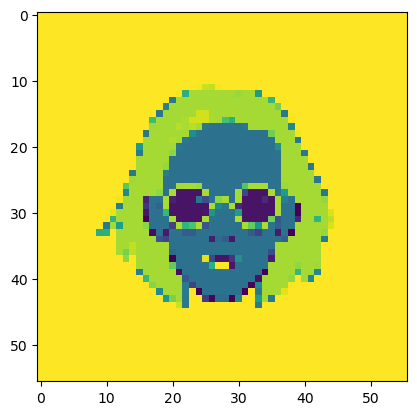

In [97]:
import notebooks.drac_CVAE as CVAE
import tensorflow as tf
import imageio
import tensorflow_probability as tfp
%run "../generacion_cartoon/data/0.1-drac-make_dataset.ipynb"
import time
import numpy as np
import glob


In [98]:
latent_dim = 2

epochs = 10

model = CVAE.CVAE(latent_dim)

/home/dracdarktime/anaconda3/envs/generacion_cartoon/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [99]:
def plot_latent_images(model, n, epoch, im_size=56, save=True, first_epoch=False, f_ep_count=0):
    
    # Create image matrix 
    image_width = im_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    # Create list of values which are evenly spaced wrt probability mass

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))

    # For each point on the grid in the latent space, decode and
    # copy the image into the image array
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (im_size, im_size))
            image[i * im_size: (i + 1) * im_size,
                  j * im_size: (j + 1) * im_size] = digit.numpy()
    

    # Plot the image array
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')

    # Potentially save, with different formatting if within first epoch
    if save and first_epoch:
        plt.savefig('tf_grid_at_epoch_{:04d}.{:04d}.png'.format(epoch, f_ep_count))
    elif save:
        plt.savefig('tf_grid_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
tf.config.run_functions_eagerly(True)
plot_latent_images(model, 20, epoch=0)

optimizer = tf.keras.optimizers.Adam(1e-4)
epochs=30
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for idx, train_x in enumerate(train_ds):
        CVAE.train_step(model, train_x, optimizer)
        if epoch == 1 and idx % 75 == 0:
            plot_latent_images(model, 20, epoch=epoch, first_epoch=True, f_ep_count=idx)          
    end_time = time.time()
    loss = tf.keras.metrics.Mean()
    for test_x in test_ds:
        loss(CVAE.compute_loss(model, test_x))
    elbo = -loss.result()
    #display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
    if epoch != 1:
        plot_latent_images(model, 20, epoch=epoch)

In [103]:
anim_file = 'grid.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('tf_grid*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        print(filename)
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

tf_grid_at_epoch_0000.png
tf_grid_at_epoch_0001.0000.png
tf_grid_at_epoch_0001.0075.png
tf_grid_at_epoch_0001.0150.png
tf_grid_at_epoch_0001.0225.png
tf_grid_at_epoch_0002.png
tf_grid_at_epoch_0003.png
tf_grid_at_epoch_0004.png
tf_grid_at_epoch_0005.png
tf_grid_at_epoch_0006.png
tf_grid_at_epoch_0007.png
tf_grid_at_epoch_0008.png
tf_grid_at_epoch_0009.png
tf_grid_at_epoch_0010.png


/tmp/ipykernel_276751/3283973344.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


tf_grid_at_epoch_0011.png
tf_grid_at_epoch_0012.png
tf_grid_at_epoch_0013.png
tf_grid_at_epoch_0014.png
tf_grid_at_epoch_0015.png
tf_grid_at_epoch_0016.png
tf_grid_at_epoch_0017.png
tf_grid_at_epoch_0018.png
tf_grid_at_epoch_0019.png
tf_grid_at_epoch_0020.png
tf_grid_at_epoch_0021.png
tf_grid_at_epoch_0022.png
tf_grid_at_epoch_0023.png
tf_grid_at_epoch_0024.png
tf_grid_at_epoch_0025.png
tf_grid_at_epoch_0026.png
tf_grid_at_epoch_0027.png
tf_grid_at_epoch_0028.png
tf_grid_at_epoch_0029.png
tf_grid_at_epoch_0030.png


/tmp/ipykernel_276751/3283973344.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [104]:
import generacion_cartoon.utils.paths as path

In [107]:
path_models = path.models_dir("modelo_30epochs.weights.h5")

In [108]:
# Guardar los pesos del modelo
model.save_weights(path_models)


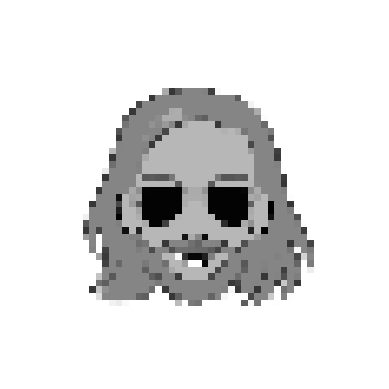

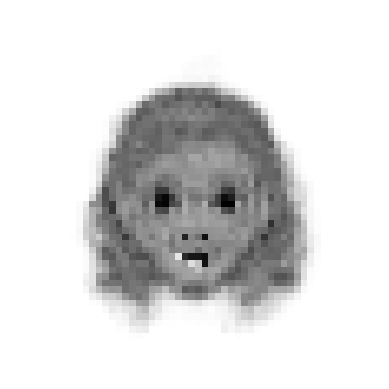

In [120]:
for i in test_ds:
    img=i
    mean, logvar = model.encode(img)
    z = model.reparameterize(mean, logvar)
    generated_image = model.decode(z, apply_sigmoid=True)
    num_img = 10
    plt.imshow(img[num_img], cmap='gray')
    plt.axis('off')
    plt.show()

    plt.imshow(generated_image[num_img].numpy().squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()
    break